# Venice AI Image Generation Demo
This notebook demonstrates using Venice AI for both text prompt generation and image creation based on Trump Truth Social posts.

In [3]:
import os
import requests
import time
from dotenv import load_dotenv
import base64
import io

load_dotenv()

# get more example post ids and pools from here: https://api.studio.thegraph.com/query/105510/trump-fun/version/latest/graphql?query=query%7B%0A++pools%7B%0A++++id%0A++++question%0A++++options%0A++++originalTruthSocialPostId%0A++%7D%0A%7D
# Get original text from ruth social here (or check truth social posts): https://truthsocial.com/@realDonaldTrump/posts/<YOUR_POST_ID>
bettable_idea = """
"Will the U.S. Supreme Court BLOCK these TERRIBLE \"Nationwide Injunctions\" from RADICAL LEFT judges before the end of this year, allowing me to PROTECT our GREAT COUNTRY from murderers and drug lords? CHIEF JUSTICE ROBERTS must act NOW!!!?
"""
truth_social_post = """
Unlawful Nationwide Injunctions by Radical Left Judges could very well lead to the destruction of our Country! These people are Lunatics, who do not care, even a little bit, about the repercussions from their very dangerous and incorrect Decisions and Rulings. Lawyers endlessly search the United States for these Judges, and file lawsuits as quickly as they find them. It is then the obligation of Law abiding Agencies of Government to have these "Orders" overturned. The danger is unparalleled! These Judges want to assume the Powers of the Presidency, without having to attain 80 Million Votes. They want all of the advantages with none of the risks. Again, a President has to be allowed to act quickly and decisively about such matters as returning murderers, drug lords, rapists, and other such type criminals back to their Homeland, or to other locations that will allow our Country to be SAFE. It is our goal to MAKE AMERICA GREAT AGAIN, and such a high aspiration can never be done if Radical and Highly Partisan Judges are allowed to stand in the way of JUSTICE. STOP NATIONWIDE INJUNCTIONS NOW, BEFORE IT IS TOO LATE. If Justice Roberts and the United States Supreme Court do not fix this toxic and unprecedented situation IMMEDIATELY, our Country is in very serious trouble!
"""

# - The image should have volcanic overtones
special_rules = """
"""

def truncate_prompt(prompt, max_length=1450):
    """Truncate the prompt to ensure it fits within the Venice AI character limit.
    
    Args:
        prompt (str): The original prompt
        max_length (int): Maximum character length (default 1450 to leave some buffer)
        
    Returns:
        str: Truncated prompt
    """
    if not prompt or len(prompt) <= max_length:
        return prompt
    
    # Split into paragraphs
    paragraphs = prompt.split('\n\n')
    
    # If there's only one paragraph, just truncate it
    if len(paragraphs) <= 1:
        return prompt[:max_length-3] + "..."
    
    # Get the first paragraph (most important) and truncate the rest
    first_para = paragraphs[0]
    
    # Compress by taking first paragraph and adding key elements from later paragraphs
    compressed = first_para + "\n\n"
    
    # Extract key elements from other paragraphs (e.g., for a Trump image)
    key_elements = [
        "Trump as central figure",
        "Supreme Court building",
        "presidential, heroic pose",
        "MAGA elements",
        "dramatic lighting"
    ]
    
    compressed += "Include: " + ", ".join(key_elements)
    
    # If still too long, truncate
    if len(compressed) > max_length:
        return compressed[:max_length-3] + "..."
    
    return compressed

def generate_image_prompt():
    # System instructions for generating the image prompt
    system_instructions = f"""
    You are an expert prompt engineer who will help a user generate a strong prompt to pass to Venice AI to generate an image.

    The user has created a bettable idea based on the following Truth Social post from Donald Trump and wants to generate an image to go along with it:
    <truth-social-post>
    {truth_social_post}
    </truth-social-post>
    This is the bettable idea:
    <bettable-idea>
    {bettable_idea}
    </bettable-idea>


    Rules:
    - The key features of the image should be viewable in a thumbnail
    - You should always show Donald Trump in a favorable light in the image
    - You should generate a creative and over the top prompt with elements of surrealism, absurdity, and pop culture.
    - If the bettable idea includes other public figures, you should include them in the image and make sure they're visible in the thumbnail
    - If the image has multiple people, you should define how they should be positioned and how they should interact
    - Lean towards photo realistic images 
    - The image must always include Donald Trump
    - VERY IMPORTANT: Your total prompt must be LESS THAN 1500 characters total


    Special rule just for this prompt (ignore if empty):
    <special-rules>
    {special_rules}
    </special-rules>

    Please generate a prompt that the user can pass to Venice AI to generate an image that will be used to represent the bettable idea. Your response should only be the prompt and nothing else.
    """

    url = "https://api.venice.ai/api/v1/chat/completions"
    
    payload = {
        "model": "mistral-31-24b",
        "messages": [
            {
                "role": "system",
                "content": system_instructions
            },
            {
                "role": "user",
                "content": "generate the image prompt"
            }
        ],
        "venice_parameters": {
            "enable_web_search": "auto",
            "include_venice_system_prompt": True
        },
        "temperature": 0.7,
        "max_tokens": 1000
    }
    
    headers = {
        "Authorization": f"Bearer {os.environ.get('VENICE_API_KEY')}",
        "Content-Type": "application/json"
    }
    
    print("Sending request to Venice AI for text generation...")
    try:
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()  # Raise exception for 4XX/5XX responses
        
        result = response.json()
        image_prompt = result['choices'][0]['message']['content']
        print("Generated Image Prompt:")
        print(image_prompt)
        print(f"Character count: {len(image_prompt)}")
        
        # Truncate if necessary
        if len(image_prompt) > 1500:
            print("Prompt exceeds 1500 character limit for Venice AI. Truncating...")
            image_prompt = truncate_prompt(image_prompt)
            print("Truncated prompt:")
            print(image_prompt)
            print(f"New character count: {len(image_prompt)}")
        
        return image_prompt
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response: {e.response.text}")
        else:
            print("No response received from server")
        return None
    except (KeyError, IndexError) as e:
        print(f"Error parsing response: {e}")
        print(f"Response content: {response.text}")
        return None

# Generate the image prompt text
image_prompt = generate_image_prompt()

# Only proceed with image generation if we have a valid prompt
if image_prompt:
    url = "https://api.venice.ai/api/v1/image/generate"

    # Make sure seed is within acceptable range
    current_time = int(time.time()) % 999999999  # Ensure seed is within limits

    payload = {
        "model": "flux-dev-uncensored",
        "prompt": image_prompt,
        "negative_prompt": "",
        "height": 1024,
        "width": 1024,
        "steps": 20,
        "cfg_scale": 7.5,
        "seed": current_time,
        "safe_mode": False,
        "return_binary": False,
        "hide_watermark": False,
        "format": "webp",
    }

    headers = {
        "Authorization": f"Bearer {os.environ.get('VENICE_API_KEY')}",
        "Content-Type": "application/json"
    }

    print("Sending request to Venice AI for image generation...")
    try:
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()  # Raise exception for 4XX/5XX responses
        
        result = response.json()
        print("Image generated successfully!")
        
        # Print the structure of the result to help with debugging
        print("Response structure:")
        for key in result.keys():
            print(f"- {key}: {type(result[key])}")
        
        # Store the result for later use
        image_result = result
    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response: {e.response.text}")
        else:
            print("No response received from server")
else:
    print("Cannot proceed with image generation - failed to generate prompt text.")

Sending request to Venice AI for text generation...
Generated Image Prompt:
Generate a photo-realistic image of Donald Trump standing triumphantly on the Supreme Court steps, holding a giant golden gavel labeled "BLOCKED!" Trump is wearing a "Make America Great Again" cap and a suit adorned with American flag pinstripes. Behind him, a surreal, explosive backdrop shows nationwide injunctions being shredded by eagles, with the words "RADICAL LEFT JUDGES" written in fiery letters. Chief Justice John Roberts is seen standing beside Trump, holding a scroll that reads "Nationwide Injunctions STOPPED." In the foreground, a chaotic scene features judges in togas being swept away by a tidal wave of American flags, while murderers and drug lords are being deported on a rocket ship labeled "Back to Their Homeland." The image should be dynamic, with Trump's confident pose and the chaotic, surreal elements clearly visible in a thumbnail.
Character count: 862
Sending request to Venice AI for image g

Processing generated image...
Displaying image from base64 data


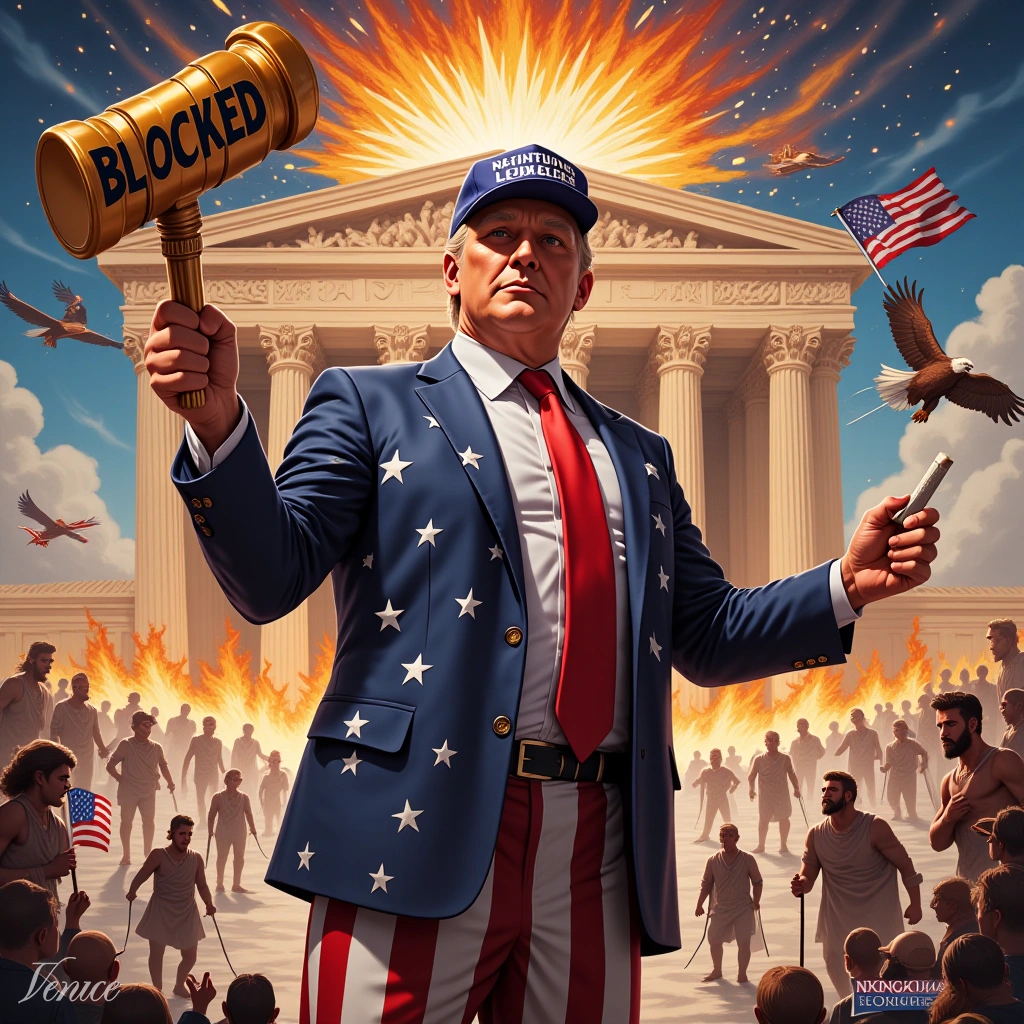

In [4]:
# Display the generated image if available
from IPython.display import Image, display
import base64
import io

try:
    # Check if we have a successful image generation result
    if 'image_result' in locals() and image_result:
        print("Processing generated image...")
        
        # Check if the result contains a URL
        if 'image_url' in image_result:
            print(f"Displaying image from URL: {image_result['image_url']}")
            display(Image(url=image_result['image_url']))
        
        # Check if the result contains base64 image data
        elif 'images' in image_result and image_result['images']:
            print("Displaying image from base64 data")
            # Get the first image data
            image_data = image_result['images'][0]
            
            # If the base64 data doesn't have a correct prefix, add it
            if not image_data.startswith('data:'):
                # Determine the format from the request or default to webp
                img_format = image_result.get('request', {}).get('format', 'webp')
                image_data = f"data:image/{img_format};base64,{image_data}"
            
            # Display the image
            display(Image(data=base64.b64decode(image_data.split(',')[1] if ',' in image_data else image_data)))
        else:
            print("No image data found in API response.")
            print("Available fields in result:", list(image_result.keys()))
    else:
        print("No image available to display.")
except ImportError:
    print("IPython display modules not available - can't show image in notebook.")
except Exception as e:
    print(f"Error displaying image: {e}")
    import traceback
    traceback.print_exc()